In [64]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import shap
from scipy.optimize import minimize
from bayes_opt import BayesianOptimization

In [65]:
# Define stock tickers for Indian market
tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS']
data = yf.download(tickers, start='2020-01-01', end='2024-01-01')["Close"]
returns = data.pct_change().dropna()

[*********************100%***********************]  5 of 5 completed


In [66]:
print(data.head)

<bound method NDFrame.head of Ticker      HDFCBANK.NS  ICICIBANK.NS      INFY.NS  RELIANCE.NS       TCS.NS
Date                                                                        
2020-01-01  1227.428589    518.854004   655.615356   668.796692  2010.578979
2020-01-02  1235.252441    522.575623   653.702393   680.182495  2001.350098
2020-01-03  1217.636841    520.884033   663.756592   681.002075  2041.235229
2020-01-06  1191.285400    508.172424   657.394897   665.208069  2041.049072
2020-01-07  1210.149048    505.465820   647.652100   675.442078  2046.057983
...                 ...           ...          ...          ...          ...
2023-12-22  1648.341187    985.813293  1523.653564  1273.848755  3760.716553
2023-12-26  1659.784912    986.606445  1505.179443  1280.304810  3732.737793
2023-12-27  1680.354126    993.695496  1527.748169  1284.675049  3748.128418
2023-12-28  1682.277710    997.314331  1523.409912  1293.961792  3737.015381
2023-12-29  1686.223877    988.093689  1504.15

In [67]:
# Define portfolio optimization function
def portfolio_performance(weights, returns):
    weights = np.array(weights)
    port_return = np.sum(returns.mean() * weights) * 252 #252 trading days in a year
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = port_return / port_volatility
    return sharpe_ratio


In [56]:
def optimize_portfolio(custom_weights=None):
    # Define the objective function for optimization
    def objective(**weights):
        weight_array = np.array(list(weights.values()))
        return portfolio_performance(weight_array, returns)

    # Define weight bounds (0 to 1 for each stock)
    pbounds = {f'w{i}': (0, 1) for i in range(len(tickers))}
    
    
    # If custom weights are provided, initialize optimizer near them
    if custom_weights is not None:
        custom_weights = np.array(custom_weights)
        custom_weights /= custom_weights.sum()  # Normalize weights

        # Set the optimizer's starting point close to the custom weights
        optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)
        for i, w in enumerate(custom_weights):
            optimizer.probe(params={f'w{i}': w}, lazy=True)  # Start from given weights
        optimizer.maximize(init_points=5, n_iter=50)

    else:
        # Run optimizer from scratch if no initial weights are provided
        optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)
        optimizer.maximize(init_points=5, n_iter=50)

    # Get optimized weights
    best_weights = np.array([optimizer.max['params'][f'w{i}'] for i in range(len(tickers))])
    best_weights /= best_weights.sum()  # Normalize the final weights
    return best_weights



In [58]:
def optimize_portfolio(custom_weights=None):
    def objective(**weights):
        weight_array = np.array(list(weights.values()))
        return portfolio_performance(weight_array, returns)

    pbounds = {f'w{i}': (0, 1) for i in range(len(tickers))}
    
    optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)

    # If custom weights are provided, probe with all weights at once
    if custom_weights is not None:
        custom_weights = np.array(custom_weights)
        custom_weights /= custom_weights.sum()  # Normalize
        
        params = {f'w{i}': custom_weights[i] for i in range(len(custom_weights))}
        optimizer.probe(params=params, lazy=True)  # Provide all weights at once
    
    optimizer.maximize(init_points=5, n_iter=50)

    best_weights = np.array([optimizer.max['params'][f'w{i}'] for i in range(len(tickers))])
    best_weights /= best_weights.sum()
    return best_weights


In [59]:
my_weights = [0.3, 0.2, 0.2, 0.15, 0.15]  # Example user input
optimized_weights = optimize_portfolio(my_weights)
print("Optimized Portfolio Weights:", optimized_weights)

|   iter    |  target   |    w0     |    w1     |    w2     |    w3     |    w4     |
-------------------------------------------------------------------------------------
| 1         | 0.8504    | 0.3       | 0.2       | 0.2       | 0.15      | 0.15      |
| 2         | 0.896     | 0.3745    | 0.9507    | 0.732     | 0.5987    | 0.156     |
| 3         | 0.9499    | 0.156     | 0.05808   | 0.8662    | 0.6011    | 0.7081    |
| 4         | 0.9258    | 0.02058   | 0.9699    | 0.8324    | 0.2123    | 0.1818    |
| 5         | 0.9473    | 0.1834    | 0.3042    | 0.5248    | 0.4319    | 0.2912    |
| 6         | 0.8465    | 0.6119    | 0.1395    | 0.2921    | 0.3664    | 0.4561    |
| 7         | 0.8834    | 0.3871    | 0.6911    | 0.258     | 0.832     | 0.6098    |
| 8         | 0.8158    | 0.9064    | 0.1054    | 0.1473    | 0.9253    | 0.7707    |
| 9         | 0.6802    | 0.584     | 0.04778   | 0.03581   | 0.1045    | 0.2332    |
| 10        | 0.9676    | 0.1111    | 0.4416    | 0.85

|   iter    |  target   |    w0     |    w1     |    w2     |    w3     |    w4     |
-------------------------------------------------------------------------------------
| 1         | 0.8504    | 0.3       | 0.2       | 0.2       | 0.15      | 0.15      |
| 2         | 0.896     | 0.3745    | 0.9507    | 0.732     | 0.5987    | 0.156     |
| 3         | 0.9499    | 0.156     | 0.05808   | 0.8662    | 0.6011    | 0.7081    |
| 4         | 0.9258    | 0.02058   | 0.9699    | 0.8324    | 0.2123    | 0.1818    |
| 5         | 0.9473    | 0.1834    | 0.3042    | 0.5248    | 0.4319    | 0.2912    |
| 6         | 0.8465    | 0.6119    | 0.1395    | 0.2921    | 0.3664    | 0.4561    |
| 7         | 0.8834    | 0.3871    | 0.6911    | 0.258     | 0.832     | 0.6098    |
| 8         | 0.8158    | 0.9064    | 0.1054    | 0.1473    | 0.9253    | 0.7707    |
| 9         | 0.6802    | 0.584     | 0.04778   | 0.03581   | 0.1045    | 0.2332    |
| 10        | 0.9676    | 0.1111    | 0.4416    | 0.85

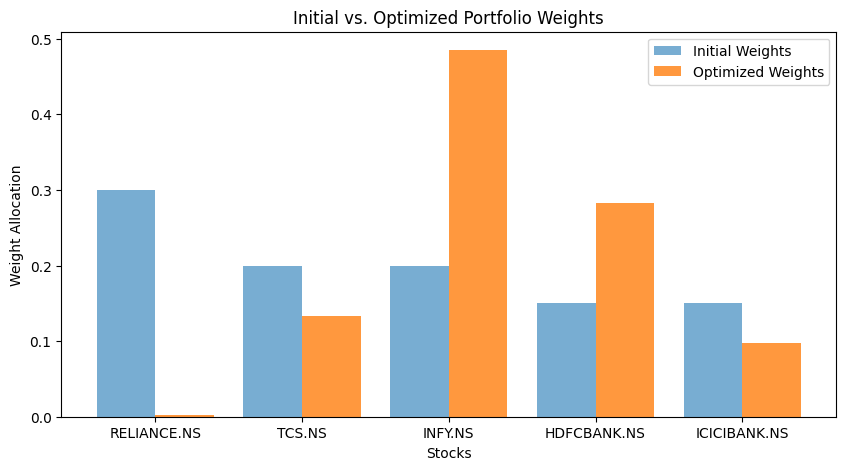

In [61]:
import matplotlib.pyplot as plt

# Plot function
def plot_weights(initial_weights, optimized_weights, tickers):
    x = range(len(tickers))  # X-axis positions
    
    plt.figure(figsize=(10, 5))
    plt.bar(x, initial_weights, width=0.4, label="Initial Weights", align='center', alpha=0.6)
    plt.bar([p + 0.4 for p in x], optimized_weights, width=0.4, label="Optimized Weights", align='center', alpha=0.8)

    plt.xticks([p + 0.2 for p in x], tickers)  # Center tick labels
    plt.ylabel("Weight Allocation")
    plt.xlabel("Stocks")
    plt.title("Initial vs. Optimized Portfolio Weights")
    plt.legend()
    plt.show()

# Example Usage
my_weights = [0.3, 0.2, 0.2, 0.15, 0.15]  # Your input weights
optimized_weights = optimize_portfolio(my_weights)  # Optimized by AI

plot_weights(my_weights, optimized_weights, tickers)  # Visualize the difference


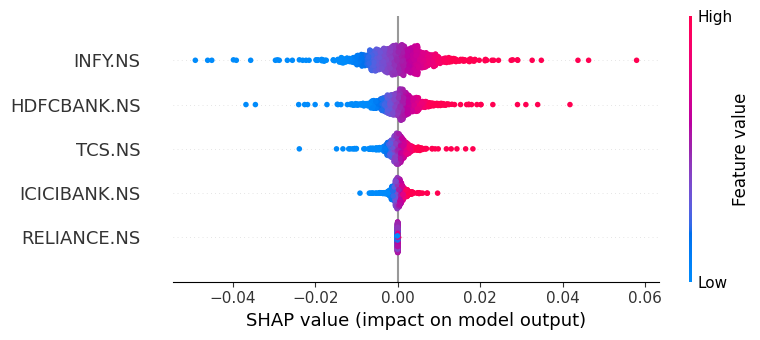

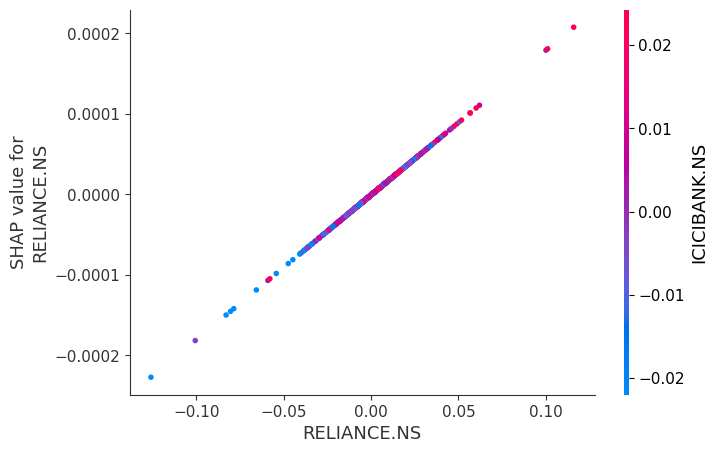

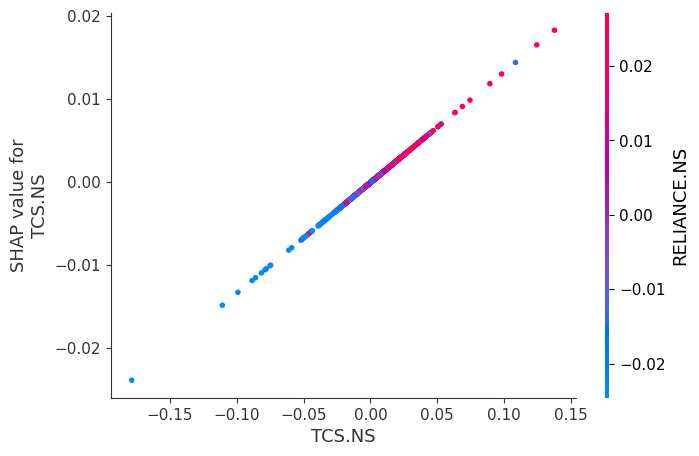

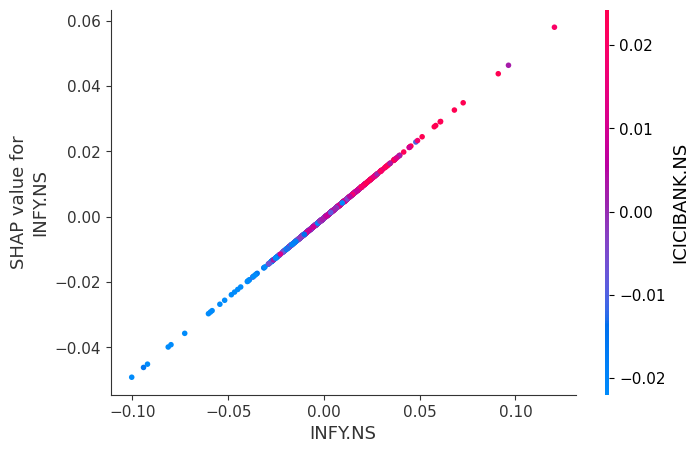

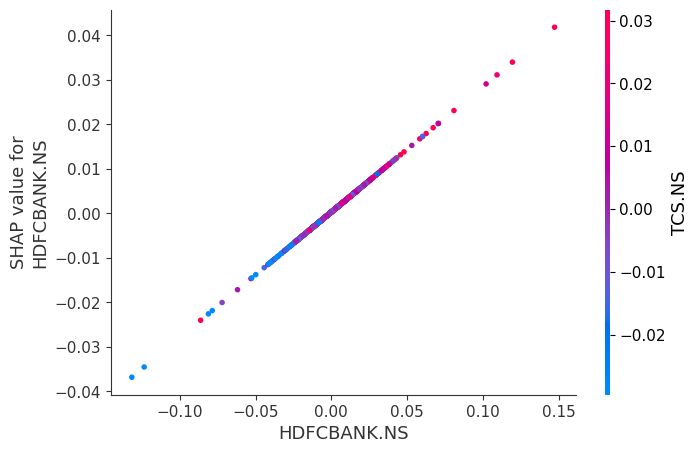

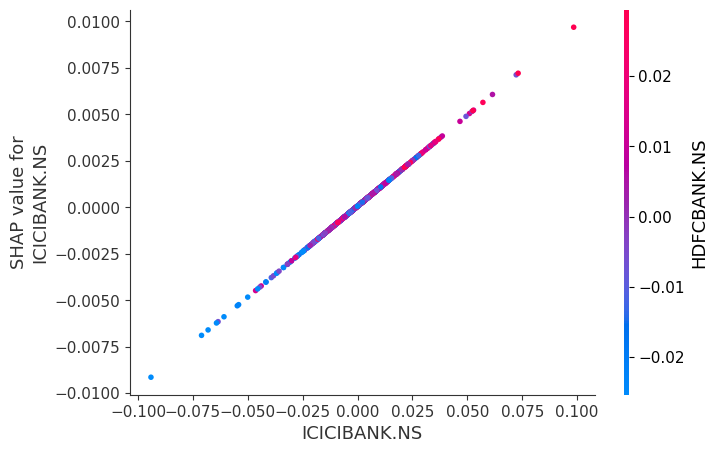

AttributeError: 'ExactExplainer' object has no attribute 'expected_value'

In [ ]:
import shap

def explain_weight_changes(optimized_weights, returns, tickers):
    explainer = shap.Explainer(lambda x: np.dot(x, optimized_weights), returns.values)
    shap_values = explainer(returns.values)

    # Summary plot - shows overall impact of each stock
    shap.summary_plot(shap_values, returns.values, feature_names=tickers)

    # Dependence plots - shows why individual stock weights changed
    for i, ticker in enumerate(tickers):
        shap.dependence_plot(i, shap_values.values, returns.values, feature_names=tickers)

    # Decision plot - shows how weights evolved
    shap.decision_plot(explainer.expected_value, shap_values.values, feature_names=tickers)

# Example Usage
explain_weight_changes(optimized_weights, returns, tickers)

In [63]:
print("Old Weights:", old_weights)
print("New Weights:", new_weights)
    

Old Weights: [0.3  0.2  0.2  0.15 0.15]
New Weights: [0.25 0.25 0.2  0.2  0.1 ]


In [ ]:
import numpy as np

def portfolio_return(weights, returns):
    """
    Calculate the portfolio return using given weights.
    
    Parameters:
    - weights (array): Array of stock weights.
    - returns (DataFrame): Historical return data of stocks.

    Returns:
    - Portfolio return (annualized).
    """
    return np.sum(returns.mean() * weights) * 252  # Assuming 252 trading days

def explain_shap_all(stocks, shap_values_dict, feature_values_dict, influencing_stocks, old_weights, new_weights, returns):
    """
    Generate a simple explanation for SHAP dependence plots and portfolio adjustment for all stocks.

    Parameters:
    - stocks (list): List of stock names.
    - shap_values_dict (dict): Dictionary containing SHAP values for each stock.
    - feature_values_dict (dict): Dictionary containing actual returns for each stock.
    - influencing_stocks (dict): Dictionary mapping each stock to its main influencer.
    - old_weights (array): Portfolio weights before optimization.
    - new_weights (array): Portfolio weights after optimization.
    - returns (DataFrame): Stock return data.

    Returns:
    - A human-readable explanation.
    """
    
    old_return = portfolio_return(old_weights, returns)
    new_return = portfolio_return(new_weights, returns)

    explanation = "Explaining the Model’s Decision for Each Stock in the Portfolio\n\n"

    for stock in stocks:
        avg_shap = np.mean(shap_values_dict[stock])
        avg_feature = np.mean(feature_values_dict[stock])
        influencing_stock = influencing_stocks.get(stock, "Unknown")

        explanation += f"🔹 {stock}:\n"

        if avg_shap > 0:
            explanation += f"Had a positive impact on the portfolio, meaning the model favored investing in it.\n"
        else:
            explanation += f"Had a negative impact**, meaning the model reduced its weight in the portfolio.\n"

        explanation += f"- The stock had an average return of **{avg_feature:.2%}**.\n"
        explanation += f"- The model **adjusted its importance** based on **{influencing_stock}.\n"

        if avg_shap > 0 and avg_feature > 0:
            explanation += f"Since {stock} performed well, the model increased its allocation.\n"
        elif avg_shap < 0 and avg_feature < 0:
            explanation += f"Because {stock} had poor performance, the model reduced its allocation.\n"
        else:
            explanation += f"The model made adjustments to balance risks, depending on {influencing_stock}’s performance.\n"

        explanation += "\n"

    explanation += f"Portfolio Return Before Optimization:{old_return:.2%}\n"
    explanation += f"Portfolio Return After Optimization:{new_return:.2%}\n"

    if new_return > old_return:
        explanation += "The AI successfully improved the portfolio's return by adjusting stock weights! \n"
    else:
        explanation += "The AI made adjustments, but external market conditions may have affected returns.\n"

    explanation += "\n This means the AI is **dynamically adjusting stock weights** based on performance patterns!\n"

    return explanation

# Example usage (Replace with actual values from your model)
stocks = ["RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS"]
shap_values_dict = {stock: np.random.normal(0, 0.01, 100) for stock in stocks}  # Replace with actual SHAP values
feature_values_dict = {stock: np.random.normal(0, 0.02, 100) for stock in stocks}  # Replace with actual returns
influencing_stocks = {
    "RELIANCE.NS": "ICICIBANK.NS",
    "TCS.NS": "HDFCBANK.NS",
    "INFY.NS": "TCS.NS",
    "HDFCBANK.NS": "INFY.NS",
    "ICICIBANK.NS": "RELIANCE.NS"
}

# Replace these with actual weight allocations before and after optimization
old_weights = np.array([0.3, 0.2, 0.2, 0.15, 0.15])
new_weights = optimal_weights  # Example optimized weights

# Replace with actual return data (Pandas DataFrame with stock returns)
returns = np.random.normal(0, 0.02, (100, 5))  # Fake data, replace with actual

print(explain_shap_all(stocks, shap_values_dict, feature_values_dict, influencing_stocks, old_weights, new_weights, returns))


Explaining the Model’s Decision for Each Stock in the Portfolio

🔹 RELIANCE.NS:
Had a negative impact**, meaning the model reduced its weight in the portfolio.
- The stock had an average return of **-0.18%**.
- The model **adjusted its importance** based on **ICICIBANK.NS.
Because RELIANCE.NS had poor performance, the model reduced its allocation.

🔹 TCS.NS:
Had a negative impact**, meaning the model reduced its weight in the portfolio.
- The stock had an average return of **-0.20%**.
- The model **adjusted its importance** based on **HDFCBANK.NS.
Because TCS.NS had poor performance, the model reduced its allocation.

🔹 INFY.NS:
Had a positive impact on the portfolio, meaning the model favored investing in it.
- The stock had an average return of **-0.32%**.
- The model **adjusted its importance** based on **TCS.NS.
The model made adjustments to balance risks, depending on TCS.NS’s performance.

🔹 HDFCBANK.NS:
Had a negative impact**, meaning the model reduced its weight in the portfol

In [50]:
old_return = portfolio_return(old_weights, returns)
new_return = portfolio_return(new_weights, returns)

print("Old Portfolio Return:", old_return)
print("New Portfolio Return:", new_return)


Old Portfolio Return: 0.11349670619512828
New Portfolio Return: 0.11349670619512828


In [7]:
# Optimize portfolio using Bayesian Optimization
def optimize_portfolio():
    def objective(**weights):
        weight_array = np.array(list(weights.values()))
        return portfolio_performance(weight_array, returns)
    
    pbounds = {f'w{i}': (0, 1) for i in range(len(tickers))}
    optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=5, n_iter=50)
    
    best_weights = np.array([optimizer.max['params'][f'w{i}'] for i in range(len(tickers))])
    best_weights /= best_weights.sum()
    return best_weights

In [ ]:
# Get optimal portfolio weights
optimal_weights = optimize_portfolio()

|   iter    |  target   |    w0     |    w1     |    w2     |    w3     |    w4     |
-------------------------------------------------------------------------------------
| 1         | 0.896     | 0.3745    | 0.9507    | 0.732     | 0.5987    | 0.156     |
| 2         | 0.9499    | 0.156     | 0.05808   | 0.8662    | 0.6011    | 0.7081    |
| 3         | 0.9258    | 0.02058   | 0.9699    | 0.8324    | 0.2123    | 0.1818    |
| 4         | 0.9473    | 0.1834    | 0.3042    | 0.5248    | 0.4319    | 0.2912    |
| 5         | 0.8465    | 0.6119    | 0.1395    | 0.2921    | 0.3664    | 0.4561    |
| 6         | 0.8834    | 0.3871    | 0.6911    | 0.258     | 0.832     | 0.6098    |
| 7         | 0.8158    | 0.9064    | 0.1054    | 0.1473    | 0.9253    | 0.7707    |
| 8         | 0.6802    | 0.584     | 0.04778   | 0.03581   | 0.1045    | 0.2332    |
| 9         | 0.9771    | 0.0       | 0.4847    | 0.892     | 0.4163    | 0.5268    |
| 10        | 0.9623    | 0.008482  | 0.3282    | 0.90

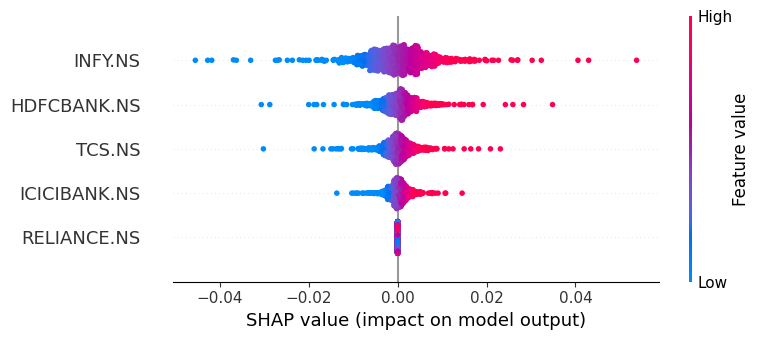

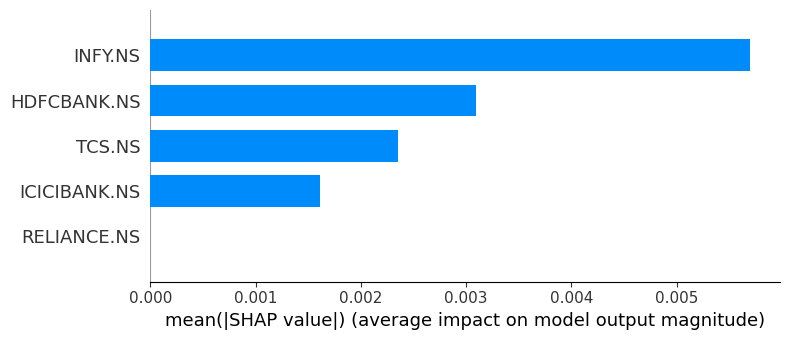

In [12]:
# Explainable AI (XAI) using SHAP
explainer = shap.Explainer(lambda x: np.dot(x, optimal_weights), returns.values)
shap_values = explainer(returns.values)
plt.figure(figsize=(10, 6))  # Adjust width and height
shap.summary_plot(shap_values, returns.values, feature_names=tickers)
shap.summary_plot(shap_values, returns.values, feature_names=tickers, plot_type = "bar")


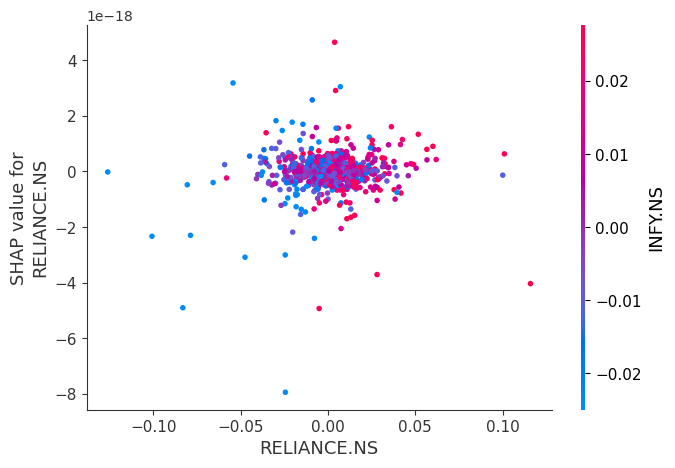

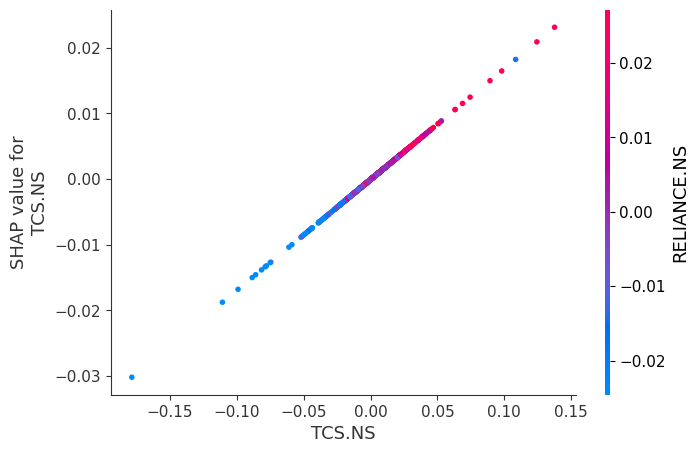

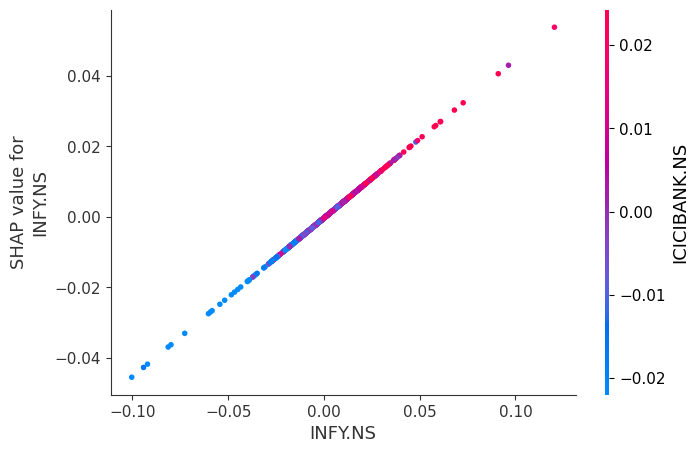

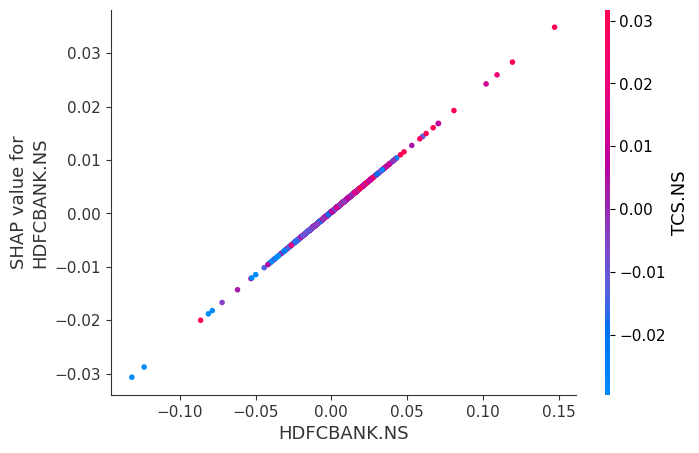

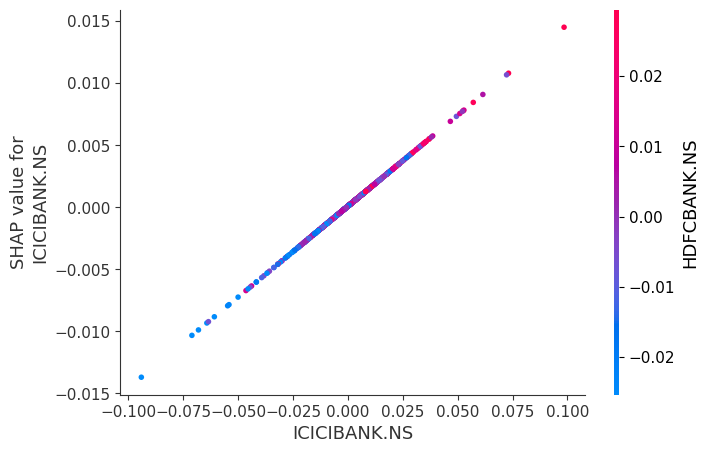

In [13]:
for i, ticker in enumerate(tickers):
    shap.dependence_plot(i, shap_values.values, returns.values, feature_names=tickers)
